## Imports

In [4]:
import pandas as pd
import numpy as np
import importlib, os, math, datetime
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
from ir_crosslingual.utils import paths
importlib.reload(paths)

from ir_crosslingual.features import text_based
importlib.reload(text_based)

from ir_crosslingual.features import vector_based
importlib.reload(vector_based)

from ir_crosslingual.supervised_classification import sup_model
importlib.reload(sup_model)

from ir_crosslingual.sentences import sentences
importlib.reload(sentences)

from ir_crosslingual.utils import helpers
importlib.reload(helpers)

<module 'ir_crosslingual.utils.helpers' from '/Users/i500969/Desktop/Admin/Uni-Mannheim/02_Courses/2020_FSS/Information-Retrieval/03_Project/03_Implementation/03_Feature-Selection/ir-crosslingual/ir_crosslingual/utils/helpers.py'>

## Load data

In [6]:
start = datetime.datetime.now()
train_file = f'{paths.data_path}extracted_data/global/training_data_tfidf.pkl'
test_file = f'{paths.data_path}extracted_data/global/test_collection_tfidf.pkl'
sens, train_data, test_collection, features = sentences.Sentences.load_from_file(train_file, test_file)
stop = datetime.datetime.now()


---- INFO: Learn projection matrix for en-de
---- INFO: Found 13700 valid translation pairs in expert dictionary.
---- INFO: 977 other pairs contained at least one unknown word (0 in source language, 977 in target language).
---- DONE: Seed dictionary extracted for the languages: en-de
---- INFO: Resulting subspace dimension: (13700, 300)
---- INFO: Resulting subspace dimension: (13700, 300)
---- DONE: Projection matrix learned from en to de
---- INFO: Learn projection matrix for de-en
---- INFO: Found 10604 valid translation pairs in expert dictionary.
---- INFO: 262 other pairs contained at least one unknown word (0 in source language, 262 in target language).
---- DONE: Seed dictionary extracted for the languages: de-en
---- INFO: Resulting subspace dimension: (10604, 300)
---- INFO: Resulting subspace dimension: (10604, 300)
---- DONE: Projection matrix learned from de to en
---- INFO: File loaded containing training data
---- INFO: File loaded containing test collection
---- DONE:

In [7]:
helpers.time(start, stop, 'loading the data from file')

---- TIME: Computation time loading the data from file: 0:02:08.785806
---- TIME: Finished at: 2020-05-13 19:58:42.838081


## Baseline model

In [9]:
label = 'translation'

In [10]:
start = datetime.datetime.now()
logReg = LogisticRegression()
logReg.fit(train_data[features], train_data[label])
stop = datetime.datetime.now()

In [11]:
helpers.time(start, stop, 'fitting the baseline model')

---- TIME: Computation time fitting the baseline model: 0:00:04.776943
---- TIME: Finished at: 2020-05-13 20:01:42.153574


In [12]:
start = datetime.datetime.now()
sup = sup_model.SupModel()
sup.evaluate_boolean(logReg, sens, features)
print('Accuracy: {}'.format(sup.accuracy))
print('Precision: {}'.format(sup.precision))
print('Recall: {}'.format(sup.recall))
print('F1: {}'.format(sup.f1))
stop = datetime.datetime.now()
helpers.time(start, stop, 'evaluating boolean')
start = datetime.datetime.now()
print('MAP: {}'.format(sup.compute_map(logReg, sens, features)))
stop = datetime.datetime.now()
helpers.time(start, stop, 'computing the MAP score')

Accuracy: 0.974674
Precision: 0.0037768659094575083
Recall: 0.9590409590409591
F1: 0.0075241006348459915
---- TIME: Computation time evaluating boolean: 0:00:20.593112
---- TIME: Finished at: 2020-05-13 20:02:05.008264
---- 13-05-2020 20:02:08 INFO: Probabilities detected
---- 13-05-2020 20:02:09 INFO: Dataframe with evaluation ranking created
---- 13-05-2020 20:10:34 INFO: Probabilities sorted for each query
---- 13-05-2020 20:10:34 INFO: Index of ranking of true translation retrieved
MAP: 0.6324625033736249
---- TIME: Computation time computing the MAP score: 0:08:30.093601
---- TIME: Finished at: 2020-05-13 20:10:35.102026


## Feature selection

In [13]:
rfecv = RFECV(estimator=LogisticRegression(), step=1, 
              cv=StratifiedKFold(n_splits=5, random_state=42), scoring='precision')

In [14]:
start = datetime.datetime.now()
rfecv.fit(train_data[features], train_data[label])
stop = datetime.datetime.now()

In [15]:
helpers.time(start, stop, 'fitting the feature selection')

---- TIME: Computation time fitting the feature selection: 0:01:50.142651
---- TIME: Finished at: 2020-05-13 20:25:23.128868


In [16]:
print(f'Optimal number of features: {rfecv.n_features_}')

Optimal number of features: 8


In [17]:
features_drop = list(train_data[features].columns[np.where(rfecv.support_ == False)[0]])
features_keep = list(train_data[features].columns[np.where(rfecv.support_ == True)[0]])

In [18]:
print('Keep the following features:\n>> {}'.format(features_keep))
print('---------------\nDrop the following features:\n>> {}'.format(features_drop))

Keep the following features:
>> ['norm_diff_translated_words', 'abs_diff_num_words', 'abs_diff_num_punctuation', 'abs_diff_occ_question_mark', 'abs_diff_occ_exclamation_mark', 'norm_diff_num_words', 'euclidean_distance', 'cosine_similarity']
---------------
Drop the following features:
>> ['rel_diff_num_words', 'rel_diff_num_punctuation', 'norm_diff_num_punctuation']


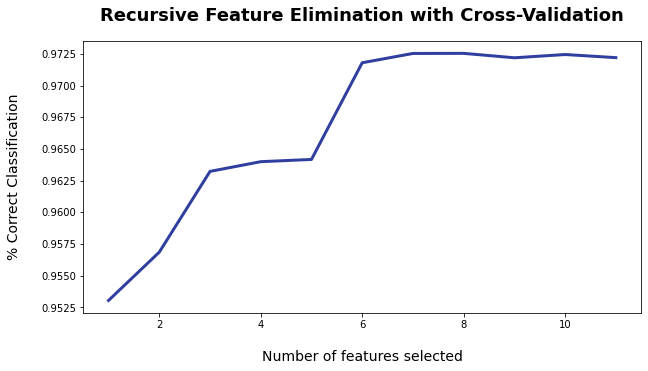

In [19]:
plt.figure(figsize=(10, 5))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

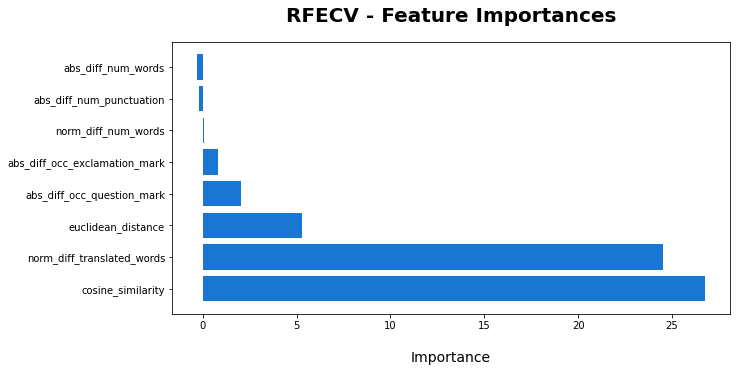

In [21]:
dset = pd.DataFrame()
dset['attr'] = features_keep
dset['importance'] = rfecv.estimator_.coef_.tolist()[0]

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(10,5))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

## Evaluation of feature selection

In [22]:
logisticRegr = LogisticRegression()
logisticRegr.fit(train_data[features_keep], train_data[label])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
# Evaluation on test collection
sup = sup_model.SupModel()
sup.evaluate_boolean(logisticRegr, sens, features_keep)
print('Accuracy: {}'.format(sup.accuracy))
print('Precision: {}'.format(sup.precision))
print('Recall: {}'.format(sup.recall))
print('F1: {}'.format(sup.f1))

print('MAP: {}'.format(sup.compute_map(logisticRegr, sens, features_keep)))

Accuracy: 0.9725616
Precision: 0.0034978878278588785
Recall: 0.962037962037962
F1: 0.006970431761427382
---- 13-05-2020 20:27:24 INFO: Probabilities detected
---- 13-05-2020 20:27:25 INFO: Dataframe with evaluation ranking created
---- 13-05-2020 20:35:24 INFO: Probabilities sorted for each query
---- 13-05-2020 20:35:24 INFO: Index of ranking of true translation retrieved
MAP: 0.618860822863259
